## 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 

from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

from sklearn.preprocessing import (
        OrdinalEncoder,
        StandardScaler,
        OneHotEncoder,
        MinMaxScaler,
        PowerTransformer,
        FunctionTransformer

)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## 2. Display Settings

In [3]:
pd.set_option("display.max_columns", None)
sklearn.set_config(transform_output='pandas')

## 3. Reat the Data

In [4]:
path = r"/home/sunny/Desktop/Flight-Sagmaker-Project/data/train.csv"
train = pd.read_csv(path)
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-05-24,Kolkata,Banglore,20:00:00,20:45:00,1485,1.0,In-flight meal not included,10844
1,Goair,2019-04-03,Banglore,Delhi,07:45:00,10:40:00,175,0.0,No Info,4239
2,Indigo,2019-03-27,Kolkata,Banglore,05:30:00,08:20:00,170,0.0,No Info,4148
3,Jet Airways,2019-03-18,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4160
4,Jet Airways,2019-05-09,Delhi,Cochin,15:00:00,12:35:00,1295,1.0,In-flight meal not included,12373


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [6]:
X_train = train.drop(columns='price')
y_train = train['price'].copy()

## 4. Transformation Opertaions

### 4.1 airline

In [7]:
X_train.airline

0            Jet Airways
1                  Goair
2                 Indigo
3            Jet Airways
4            Jet Airways
             ...        
635          Jet Airways
636    Multiple Carriers
637          Jet Airways
638               Indigo
639          Jet Airways
Name: airline, Length: 640, dtype: object

In [8]:
# airline is categorical column
air_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('grouper', RareLabelEncoder(tol=0.1, n_categories=2, replace_with='Other')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
     
])
air_transformer.fit_transform(X_train.loc[:, ['airline']])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Other
0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
635,0.0,0.0,1.0,0.0
636,0.0,0.0,0.0,1.0
637,0.0,0.0,1.0,0.0
638,0.0,1.0,0.0,0.0


## 4.2 date_of_journey

In [9]:
X_train.date_of_journey

0      2019-05-24
1      2019-04-03
2      2019-03-27
3      2019-03-18
4      2019-05-09
          ...    
635    2019-03-18
636    2019-05-24
637    2019-03-24
638    2019-06-09
639    2019-05-15
Name: date_of_journey, Length: 640, dtype: object

In [10]:
feature_to_extract = ['month', 'week', 'day_of_week', 'day_of_month', 'day_of_year']

doj_transformer = Pipeline(steps=[
    ('dt', DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format='mixed')),
    ('scaler', MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ['date_of_journey']])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_month,date_of_journey_day_of_year
0,0.666667,0.705882,0.666667,0.884615,0.711864
1,0.333333,0.294118,0.333333,0.076923,0.279661
2,0.000000,0.235294,0.333333,1.000000,0.220339
3,0.000000,0.176471,0.000000,0.653846,0.144068
4,0.666667,0.588235,0.500000,0.307692,0.584746
...,...,...,...,...,...
635,0.000000,0.176471,0.000000,0.653846,0.144068
636,0.666667,0.705882,0.666667,0.884615,0.711864
637,0.000000,0.176471,1.000000,0.884615,0.194915
638,1.000000,0.823529,1.000000,0.307692,0.847458


## source & destination

In [11]:
X_train.source

0       Kolkata
1      Banglore
2       Kolkata
3        Mumbai
4         Delhi
         ...   
635    Banglore
636       Delhi
637      Mumbai
638     Kolkata
639     Kolkata
Name: source, Length: 640, dtype: object

In [12]:
X_train.destination

0       Banglore
1          Delhi
2       Banglore
3      Hyderabad
4         Cochin
         ...    
635    New Delhi
636       Cochin
637    Hyderabad
638     Banglore
639     Banglore
Name: destination, Length: 640, dtype: object

In [13]:
location_subset = X_train.loc[:, ['source', 'destination']]
location_subset

,source,destination
0,Kolkata,Banglore
1,Banglore,Delhi
2,Kolkata,Banglore
3,Mumbai,Hyderabad
4,Delhi,Cochin
...,...,...
635,Banglore,New Delhi
636,Delhi,Cochin
637,Mumbai,Hyderabad
638,Kolkata,Banglore


In [14]:
location_pipe1 = Pipeline(steps=[
    ('grouper', RareLabelEncoder(tol=0.1,replace_with='Other', n_categories=2)),
    ('encoer' , MeanEncoder()),
    ('scaler' , PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,-0.241814,-0.273227
1,-0.926482,-1.906881
2,-0.241814,-0.273227
3,-1.896087,-0.795248
4,1.009536,1.005984
...,...,...
635,-0.926482,-0.795248
636,1.009536,1.005984
637,-1.896087,-0.795248
638,-0.241814,-0.273227


In [15]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [16]:
# new and custom feature

def is_north(X):
    columns = X.columns.to_list()
    north_cities = ['Delhi', 'New Delhi', 'Kolkata', 'Mumbai']
    return (
        X.assign(**{
            f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0
...,...,...
635,0,1
636,1,0
637,1,0
638,1,0


In [17]:
location_transformer=FeatureUnion(transformer_list=[
    ('part1', location_pipe1),
    ('part2', FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-0.241814,-0.273227,1,0
1,-0.926482,-1.906881,0,1
2,-0.241814,-0.273227,1,0
3,-1.896087,-0.795248,1,0
4,1.009536,1.005984,1,0
...,...,...,...,...
635,-0.926482,-0.795248,0,1
636,1.009536,1.005984,1,0
637,-1.896087,-0.795248,1,0
638,-0.241814,-0.273227,1,0


## dep_time & arrival_time

In [18]:
X_train.dep_time

0      20:00:00
1      07:45:00
2      05:30:00
3      10:20:00
4      15:00:00
         ...   
635    16:55:00
636    19:00:00
637    15:50:00
638    21:00:00
639    18:55:00
Name: dep_time, Length: 640, dtype: object

In [19]:
X_train.arrival_time

0      20:45:00
1      10:40:00
2      08:20:00
3      11:50:00
4      12:35:00
         ...   
635    10:25:00
636    01:30:00
637    17:20:00
638    02:15:00
639    20:45:00
Name: arrival_time, Length: 640, dtype: object

In [20]:
time_subset = X_train.loc[:,['dep_time', 'arrival_time']]
time_subset

,dep_time,arrival_time
0,20:00:00,20:45:00
1,07:45:00,10:40:00
2,05:30:00,08:20:00
3,10:20:00,11:50:00
4,15:00:00,12:35:00
...,...,...
635,16:55:00,10:25:00
636,19:00:00,01:30:00
637,15:50:00,17:20:00
638,21:00:00,02:15:00


In [21]:
time_pipe1 = Pipeline(steps=[
    ('dt', DatetimeFeatures(features_to_extract=['hour','minute'])),
    ('scaler', MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.869565,0.000000,0.869565,0.818182
1,0.304348,0.818182,0.434783,0.727273
2,0.217391,0.545455,0.347826,0.363636
3,0.434783,0.363636,0.478261,0.909091
4,0.652174,0.000000,0.521739,0.636364
...,...,...,...,...
635,0.695652,1.000000,0.434783,0.454545
636,0.826087,0.000000,0.043478,0.545455
637,0.652174,0.909091,0.739130,0.363636
638,0.913043,0.000000,0.086957,0.272727


In [22]:
def part_of_day(X, morning=4, noon=12, evening=16, night=20):
    columns = X.columns.to_list()
    X_temp  = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour for col in columns
    })
    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:, col].between(morning, noon, inclusive='left'),
                 X_temp.loc[:, col].between(noon, evening, inclusive='left'),
                 X_temp.loc[:, col].between(evening, night, inclusive='left')
                ],
                ['morning', 'afternoon', 'evening'],
                default='night'
            ) 
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,night,night
1,morning,morning
2,morning,morning
3,morning,morning
4,afternoon,afternoon
...,...,...
635,evening,morning
636,evening,night
637,afternoon,evening
638,night,night


In [23]:
time_pipe2 = Pipeline(steps=[
    ('part', FunctionTransformer(func=part_of_day)),
    ('encoder', CountFrequencyEncoder()),
    ('scaler' , MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.195455,1.000000
1,1.000000,0.961165
2,1.000000,0.961165
3,1.000000,0.961165
4,0.000000,0.000000
...,...,...
635,0.222727,0.961165
636,0.222727,1.000000
637,0.000000,0.679612
638,0.195455,1.000000


In [24]:
time_transformer = FeatureUnion(transformer_list=[
    ('part1', time_pipe1),
    ('part2', time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.869565,0.000000,0.869565,0.818182,0.195455,1.000000
1,0.304348,0.818182,0.434783,0.727273,1.000000,0.961165
2,0.217391,0.545455,0.347826,0.363636,1.000000,0.961165
3,0.434783,0.363636,0.478261,0.909091,1.000000,0.961165
4,0.652174,0.000000,0.521739,0.636364,0.000000,0.000000
...,...,...,...,...,...,...
635,0.695652,1.000000,0.434783,0.454545,0.222727,0.961165
636,0.826087,0.000000,0.043478,0.545455,0.222727,1.000000
637,0.652174,0.909091,0.739130,0.363636,0.000000,0.679612
638,0.913043,0.000000,0.086957,0.272727,0.195455,1.000000


## 4.5 duration

In [25]:
X_train.duration

0      1485
1       175
2       170
3        90
4      1295
       ... 
635    1050
636     390
637      90
638     315
639    1550
Name: duration, Length: 640, dtype: int64

In [26]:
duration = X_train[['duration']]
duration

,duration
0,1485
1,175
2,170
3,90
4,1295
...,...
635,1050
636,390
637,90
638,315


In [27]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [28]:
(
    X_train
    .duration
    .quantile([0.25, 0.5, 0.75])
    .values
    .reshape([-1, 1])
    .shape
)

(3, 1)

In [29]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [30]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,0.0,1.000000,1.000000
1,0.000000e+00,0.0,0.904837,0.904837
2,0.000000e+00,0.0,0.904837,0.904837
3,0.000000e+00,0.0,0.904837,0.904837
4,0.000000e+00,0.0,1.000000,1.000000
...,...,...,...,...
635,0.000000e+00,0.0,1.000000,1.000000
636,1.135971e-88,0.0,1.000000,1.000000
637,0.000000e+00,0.0,0.904837,0.904837
638,8.194013e-40,0.0,1.000000,1.000000


In [31]:
def is_over(X, value=1000):
    return (
        X
        .assign(**{
            f"duration_over_{value}": X.duration.ge(value).astype(int)
        })
        .drop(columns='duration')
    )

In [32]:
dr = pd.DataFrame(duration)

In [33]:
is_over(dr)

,duration_over_1000
0,1
1,0
2,0
3,0
4,1
...,...
635,1
636,0
637,0
638,0


In [34]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.335996,-0.088625,-0.098701,2.0,1,1.664009
1,3.194193,-0.088625,-0.098701,0.0,0,-0.909843
2,2.863948,-0.088625,-0.098701,0.0,0,-0.919667
3,-0.335996,-0.088625,-0.098701,0.0,0,-1.076849
4,-0.335996,-0.088625,-0.098701,2.0,1,1.290702
...,...,...,...,...,...,...
635,-0.335996,-0.088625,-0.098701,2.0,1,0.809333
636,-0.335996,-0.088625,-0.098701,1.0,0,-0.487417
637,-0.335996,-0.088625,-0.098701,0.0,0,-1.076849
638,-0.335996,-0.088625,-0.098701,1.0,0,-0.634775


## 4.6 total_stops

In [35]:
X_train.total_stops

0      1.0
1      0.0
2      0.0
3      0.0
4      1.0
      ... 
635    1.0
636    1.0
637    0.0
638    1.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [36]:
def is_direct(X):
    return X.assign(is_direct_flight = X.total_stops.eq(0).astype(int))

total_stops_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ['total_stops']])

,total_stops,is_direct_flight
0,1.0,0
1,0.0,1
2,0.0,1
3,0.0,1
4,1.0,0
...,...,...
635,1.0,0
636,1.0,0
637,0.0,1
638,1.0,0


## 4.7 additional_info

In [37]:
X_train.additional_info

0      In-flight meal not included
1                          No Info
2                          No Info
3      In-flight meal not included
4      In-flight meal not included
                  ...             
635    In-flight meal not included
636                        No Info
637    In-flight meal not included
638                        No Info
639    In-flight meal not included
Name: additional_info, Length: 640, dtype: object

In [38]:
info_pipe1 = Pipeline(steps=[
    ('grouper', RareLabelEncoder(tol=0.1, n_categories=2, replace_with='Other')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ['additional_info']])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
635,1.0,0.0,0.0
636,0.0,1.0,0.0
637,1.0,0.0,0.0
638,0.0,1.0,0.0


In [39]:
def have_info(X):
    return X.assign(additional_info=X.additional_info.ne('No Info').astype(int))

In [40]:
info_union = FeatureUnion(transformer_list=[
    ('part1', info_pipe1),
    ('part2', FunctionTransformer(func=have_info))
])

In [41]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,1.0,0.0,0.0,1
4,1.0,0.0,0.0,1
...,...,...,...,...
635,1.0,0.0,0.0,1
636,0.0,1.0,0.0,0
637,1.0,0.0,0.0,1
638,0.0,1.0,0.0,0


## 4.8 Column Transformer

In [42]:


column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)



,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_month,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.666667,0.705882,0.666667,0.884615,0.711864,-0.241814,-0.273227,1,0,0.869565,0.000000,0.869565,0.818182,0.195455,1.000000,-0.335996,-0.088625,-0.098701,2.0,1,1.664009,1.0,0,1.0,0.0,0.0,1
1,0.0,0.0,0.0,1.0,0.333333,0.294118,0.333333,0.076923,0.279661,-0.926482,-1.906881,0,1,0.304348,0.818182,0.434783,0.727273,1.000000,0.961165,3.194193,-0.088625,-0.098701,0.0,0,-0.909843,0.0,1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0.0,0.000000,0.235294,0.333333,1.000000,0.220339,-0.241814,-0.273227,1,0,0.217391,0.545455,0.347826,0.363636,1.000000,0.961165,2.863948,-0.088625,-0.098701,0.0,0,-0.919667,0.0,1,0.0,1.0,0.0,0
3,0.0,0.0,1.0,0.0,0.000000,0.176471,0.000000,0.653846,0.144068,-1.896087,-0.795248,1,0,0.434783,0.363636,0.478261,0.909091,1.000000,0.961165,-0.335996,-0.088625,-0.098701,0.0,0,-1.076849,0.0,1,1.0,0.0,0.0,1
4,0.0,0.0,1.0,0.0,0.666667,0.588235,0.500000,0.307692,0.584746,1.009536,1.005984,1,0,0.652174,0.000000,0.521739,0.636364,0.000000,0.000000,-0.335996,-0.088625,-0.098701,2.0,1,1.290702,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.000000,0.176471,0.000000,0.653846,0.144068,-0.926482,-0.795248,0,1,0.695652,1.000000,0.434783,0.454545,0.222727,0.961165,-0.335996,-0.088625,-0.098701,2.0,1,0.809333,1.0,0,1.0,0.0,0.0,1
636,0.0,0.0,0.0,1.0,0.666667,0.705882,0.666667,0.884615,0.711864,1.009536,1.005984,1,0,0.826087,0.000000,0.043478,0.545455,0.222727,1.000000,-0.335996,-0.088625,-0.098701,1.0,0,-0.487417,1.0,0,0.0,1.0,0.0,0
637,0.0,0.0,1.0,0.0,0.000000,0.176471,1.000000,0.884615,0.194915,-1.896087,-0.795248,1,0,0.652174,0.909091,0.739130,0.363636,0.000000,0.679612,-0.335996,-0.088625,-0.098701,0.0,0,-1.076849,0.0,1,1.0,0.0,0.0,1
638,0.0,1.0,0.0,0.0,1.000000,0.823529,1.000000,0.307692,0.847458,-0.241814,-0.273227,1,0,0.913043,0.000000,0.086957,0.272727,0.195455,1.000000,-0.335996,-0.088625,-0.098701,1.0,0,-0.634775,1.0,0,0.0,1.0,0.0,0


## 5. Feature Selection

In [53]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)
selector = SelectBySingleFeaturePerformance(
    estimator = estimator,
    scoring = 'r2',
    threshold=0.06
)

## 6. Putting it all Together

In [48]:
preprocessor = Pipeline(steps=[
    ('ct', column_transformer),
    ('selector', selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,time__arrival_time_hour,dur__duration_rbf_25,dur__duration_cat,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.666667,0.705882,0.711864,-0.241814,-0.273227,0.869565,-0.335996,2.0,1.664009,1.0,0
1,0.0,0.0,0.333333,0.294118,0.279661,-0.926482,-1.906881,0.434783,3.194193,0.0,-0.909843,0.0,1
2,1.0,0.0,0.000000,0.235294,0.220339,-0.241814,-0.273227,0.347826,2.863948,0.0,-0.919667,0.0,1
3,0.0,1.0,0.000000,0.176471,0.144068,-1.896087,-0.795248,0.478261,-0.335996,0.0,-1.076849,0.0,1
4,0.0,1.0,0.666667,0.588235,0.584746,1.009536,1.005984,0.521739,-0.335996,2.0,1.290702,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.000000,0.176471,0.144068,-0.926482,-0.795248,0.434783,-0.335996,2.0,0.809333,1.0,0
636,0.0,0.0,0.666667,0.705882,0.711864,1.009536,1.005984,0.043478,-0.335996,1.0,-0.487417,1.0,0
637,0.0,1.0,0.000000,0.176471,0.194915,-1.896087,-0.795248,0.739130,-0.335996,0.0,-1.076849,0.0,1
638,1.0,0.0,1.000000,0.823529,0.847458,-0.241814,-0.273227,0.086957,-0.335996,1.0,-0.634775,1.0,0


## 7. Visualizations

In [54]:
feature_performances = preprocessor.named_steps['selector'].feature_performance_
feature_performances

{'air__airline_Air India': 0.0004497356542847812,
 'air__airline_Indigo': 0.12310603045734592,
 'air__airline_Jet Airways': 0.11458699121877707,
 'air__airline_Other': 0.0015916478819087605,
 'doj__date_of_journey_month': 0.07397340925215572,
 'doj__date_of_journey_week': 0.23123330138245843,
 'doj__date_of_journey_day_of_week': -0.0065629669427981945,
 'doj__date_of_journey_day_of_month': 0.0027095060008710536,
 'doj__date_of_journey_day_of_year': 0.29095221592475945,
 'location__source': 0.08221385203138314,
 'location__destination': 0.08659647668638386,
 'location__source_is_north': 0.020305234054706595,
 'location__destination_is_north': 0.020305234054706595,
 'time__dep_time_hour': -0.015401571431776487,
 'time__dep_time_minute': 0.010798983448939148,
 'time__arrival_time_hour': 0.07384317768184363,
 'time__arrival_time_minute': 0.009905180651448298,
 'time__dep_time_part_of_day': -0.014296270933114771,
 'time__arrival_time_part_of_day': 0.013652498170560948,
 'dur__duration_rbf_2

In [60]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'info__additional_info_Other': -0.016964376637935447,
 'time__dep_time_hour': -0.015401571431776487,
 'time__dep_time_part_of_day': -0.014296270933114771,
 'info__additional_info_No Info': -0.007884040299468284,
 'info__additional_info': -0.007884040299468284,
 'info__additional_info_In-flight meal not included': -0.007778225049018446,
 'doj__date_of_journey_day_of_week': -0.0065629669427981945,
 'dur__duration_rbf_75': -0.006208031438150667,
 'dur__duration_rbf_50': -0.002944267710413303,
 'air__airline_Air India': 0.0004497356542847812,
 'air__airline_Other': 0.0015916478819087605,
 'doj__date_of_journey_day_of_month': 0.0027095060008710536,
 'time__arrival_time_minute': 0.009905180651448298,
 'time__dep_time_minute': 0.010798983448939148,
 'time__arrival_time_part_of_day': 0.013652498170560948,
 'location__source_is_north': 0.020305234054706595,
 'location__destination_is_north': 0.020305234054706595,
 'dur__duration_over_1000': 0.05781667129874949,
 'time__arrival_time_hour': 0.07

In [58]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'info__additional_info_Other': -0.016964376637935447,
 'time__dep_time_hour': -0.015401571431776487,
 'time__dep_time_part_of_day': -0.014296270933114771,
 'info__additional_info_No Info': -0.007884040299468284,
 'info__additional_info': -0.007884040299468284,
 'info__additional_info_In-flight meal not included': -0.007778225049018446,
 'doj__date_of_journey_day_of_week': -0.0065629669427981945,
 'dur__duration_rbf_75': -0.006208031438150667,
 'dur__duration_rbf_50': -0.002944267710413303,
 'air__airline_Air India': 0.0004497356542847812,
 'air__airline_Other': 0.0015916478819087605,
 'doj__date_of_journey_day_of_month': 0.0027095060008710536,
 'time__arrival_time_minute': 0.009905180651448298,
 'time__dep_time_minute': 0.010798983448939148,
 'time__arrival_time_part_of_day': 0.013652498170560948,
 'location__source_is_north': 0.020305234054706595,
 'location__destination_is_north': 0.020305234054706595,
 'dur__duration_over_1000': 0.05781667129874949,
 'time__arrival_time_hour': 0.07

In [62]:
threshold=0.06

selected_bar = None
dropped_bar  = None

colors = ['red' if score<threshold else 'green' for score in sorted_feat_imp.values()]

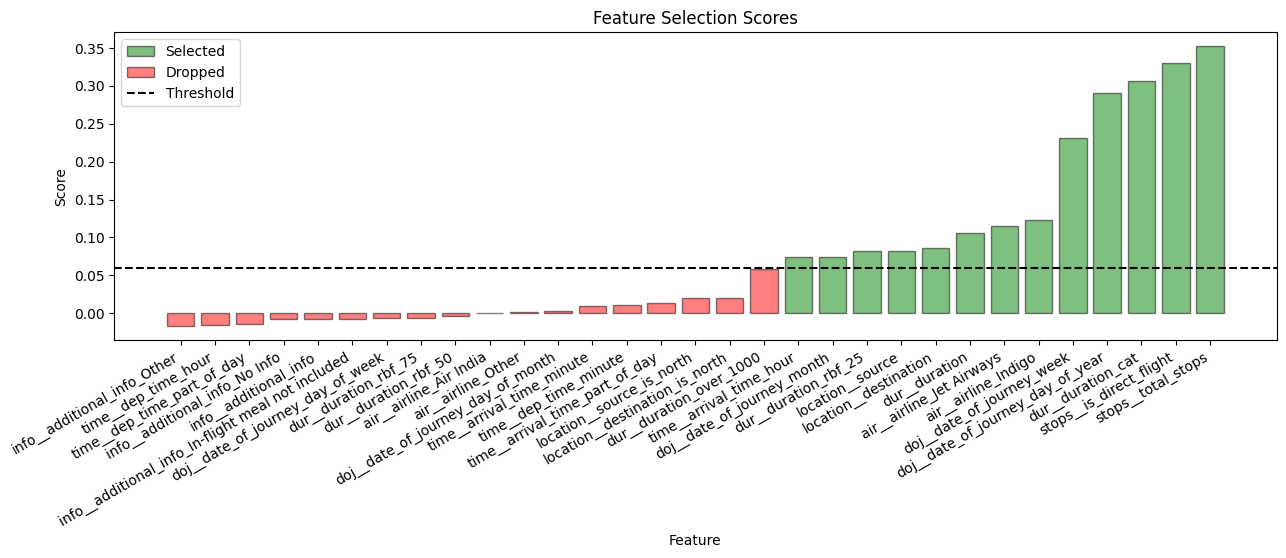

In [82]:
fig, ax = plt.subplots(1,1,figsize=(15, 4))

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
    params = dict(
        x=i,
        height=score,
        edgecolor='black',
        alpha = 0.5
    )

    if score < threshold:
        bar = ax.bar(
            color='red',
            **params
        )
        if not dropped_bar:
            dropped_bar = bar[0]

    else:
        bar = ax.bar(
            color='green',
            **params
        )
        if not selected_bar:
            selected_bar = bar[0]
            

thres_line = ax.axhline(
    y=0.06,
    color='black',
    linestyle='--'
)
ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.set_xticks(
    ticks=range(len(sorted_feat_imp)),
    labels = list(sorted_feat_imp.keys()),
    rotation=30,
    ha = 'right'
)

ax.legend(
    handles = [selected_bar, dropped_bar, thres_line],
    labels =  ['Selected', 'Dropped', 'Threshold'],
    loc = 'upper left'
)

plt.show()

- The dataset went upto 31 columns after Feature Engineering
- The Feature Selection algorithm selected 13 features out of that